In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn import preprocessing
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
#from sklearn.metrics import RocCurveDisplay
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date

import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys

def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()
    
def remap_df(lon,lat,k,date_idx):
    '''
    Remap dataframe to a netcdf grid.
    '''
    row_length = date_idx.sum()
    lon = lon.values.reshape(row_length,1)
    lat = lat.values.reshape(row_length,1)
    k = k.reshape(row_length,1)
    for row_lp in range(0, row_length):
        a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
        i,j = np.unravel_index(a.argmin(),a.shape)
        k_means_array[i,j] = k[row_lp]
    print('Done!')

    return k_means_array


def miz_width(ds, year, time_step):
    # Calculate MIZ width
    n_days, n_lat, n_lon = ds['k'].shape
    miz_cluster = 0 # What cluster does the MIZ correspond with?

    # Initialise arrays
    miz_width_array = np.empty((n_days,n_lon))
    effective_miz_width_array = np.empty((n_days,n_lon))
    sic_width_array = np.empty((n_days,n_lon))


    day_vec = range(0,n_days, time_step)


    mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    onlyfiles = onlyfiles[0:n_days:time_step]

    # Circumpolar for each day
    for day_tmp, filename in enumerate(onlyfiles):
        day_idx = day_vec[day_tmp]
        progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
        ShowBar(progressBar)
        ds_day = xr.open_dataset(filename)

        for lon_idx in range(0,n_lon):
            # MIZ width
            miz_idx = ds['k'][day_idx,:,lon_idx].data == miz_cluster
    #        locs = [i for i, x in enumerate(np.diff(miz_idx)) if x]
    #        if len(locs) >= 2:
    #            miz_idx[0:locs[-2]] = False
            sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
            miz_idx = miz_idx*sic_idx
            sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
            if not any(miz_idx):
                # If there are no MIZ cells then set distance to 0
                miz_width_array[day_idx,lon_idx] = 0
                effective_miz_width_array[day_idx,lon_idx] = 0
            else:
                miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
                effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()

            if not any(sic_1580_idx):
                sic_width_array[day_idx,lon_idx] = 0
            else:
                sic_width_array[day_idx,lon_idx] = ds['HTE'][sic_1580_idx,lon_idx].data.sum()
    print('Done!')

    return miz_width_array, effective_miz_width_array, sic_width_array

In [3]:
## Variable selection

# Read in the data
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
year = 2019
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+str(year)+'.csv')
n_clusters = 3
kmeans = KMeans(
    init='random',#'k-means++',
    n_clusters=n_clusters,
#    n_init=1,
    n_init=10,
    max_iter=100,
#    random_state=1,#100,
    algorithm="lloyd",
    copy_x=True
)
print(str(n_clusters))
X_train = np.asarray(df_standard.iloc[:, [1,2,3,5]])
predicted = kmeans.fit(X_train)
sort_idx = kmeans.cluster_centers_[:, 1].argsort()
kmeans.cluster_centers_ = kmeans.cluster_centers_[sort_idx]
predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)

df_kmeans = df_standard
df_kmeans['k'] = predicted

# Convert the dataframes to netcdf
print(str([1235]))
#df_read = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/'+'kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.csv')
savefilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_1235_'+str(year)+'.nc'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
map_to_netcdf(df_kmeans,savefilename,mypath,year)

3


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


[[0.40020866 0.09058127 0.03591475 0.15156641]
 [0.96874856 0.13739478 0.08231218 0.07503758]
 [0.97707933 0.31835281 0.31944508 0.16803371]]
[1235]


NameError: name 'map_to_netcdf' is not defined

In [ ]:
# Removing floe size
print(str(n_clusters))
X_train = np.asarray(df_standard.iloc[:, [1,2,3,5]])
predicted = kmeans.fit(X_train)
#sort_idx = kmeans.cluster_centers_[:, 1].argsort()
#kmeans.cluster_centers_ = kmeans.cluster_centers_[sort_idx]
predicted = kmeans.predict(X_train) 
print(kmeans.cluster_centers_)

df_1235 = predicted

k_means_array_1235 = remap_df(lon,lat,df_1235[date_idx],date_idx)

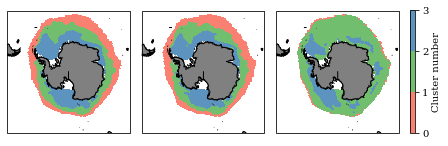

In [7]:
# Plot this on a map        
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]

# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# define the bins and normalize
bounds = np.linspace(0, 3, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make the map
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)

fig, axs = plt.subplot_mosaic([['a)','b)','c)']],
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(6.4, 3))
plt.rcParams["font.family"] = "serif"
n_clusters = 3
n_var = 0
for label, ax in axs.items():
    if label == 'a)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_12345_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = cmap
    elif label == 'b)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = mpl.colors.ListedColormap([(0.3639, 0.5755, 0.748, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.9805, 0.5000, 0.4453, 1.0)])
    elif label == 'c)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1235_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = cmap
        
#    print('yes')
    cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmaptmp,
            norm=norm,
            shading='auto')     

    # label physical distance in and down:
#    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
#            fontsize='large', verticalalignment='top', fontfamily='serif',
#            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
    ax.set_extent(coord_lims, ccrs.PlateCarree())

    # Add coastlines
    ax.add_feature(land_50m)
    ax.coastlines()


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.9,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.925, 0.165, 0.01, 0.57])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 



# Inset plots
# n_days = 365
# left, bottom, width, height = [0.2, 0.45, 0.04, 0.08]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(
#     range(0,n_days,1),
#     accuracy_sic,
#     label=f"SIC",
#     color="lightskyblue",
#     linestyle="-",
#     linewidth=2,
# )
# # Hide X and Y axes label marks
# ax.xaxis.set_tick_params(labelbottom=False)
# ax.yaxis.set_tick_params(labelleft=False)

# # Hide X and Y axes tick marks
# ax.set_xticks([])
# ax.set_yticks([])

#ax2.set_xlabel('Strain (in/in)')
#ax2.set_ylabel('Accuracy')
#ax2.set_title('Inset of Elastic Region')
#ax2.set_xlim([0,0.008])
#ax2.set_ylim([0,1])



savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'kmeans_map_varying'+'_variables_'+str(year)+'.png', dpi = 600, bbox_inches='tight')  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

## ROC and acccuracy tests

NameError: name 'mtransforms' is not defined

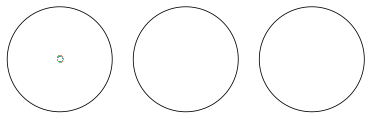

In [4]:
# Plot this on a map        
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,5,1)
year = 2019
coord_lims = [-180, 180, -50, -90]

# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# define the bins and normalize
bounds = np.linspace(0, 3, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make the map
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)

fig, axs = plt.subplot_mosaic([['a)','b)','c)']],
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(6.4, 3))
plt.rcParams["font.family"] = "serif"
n_clusters = 3
n_var = 0
for label, ax in axs.items():
    if label == 'a)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_12345_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = cmap
    elif label == 'b)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = mpl.colors.ListedColormap([(0.3639, 0.5755, 0.748, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.9805, 0.5000, 0.4453, 1.0)])
    elif label == 'c)':
        readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1235_2019.nc'
        ds = xr.open_dataset(readfilename)
        plot_data = ds['k'][243,:,:]
        cmaptmp = cmap
        
#    print('yes')
    cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:],  plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmaptmp,
            norm=norm,
            shading='auto')     

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
    ax.set_extent(coord_lims, ccrs.PlateCarree())

    # Add coastlines
    ax.add_feature(land_50m)
    ax.coastlines()


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.9,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.925, 0.165, 0.01, 0.57])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', label='Cluster number') 



# Inset plots
n_days = 365
left, bottom, width, height = [0.2, 0.45, 0.04, 0.08]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(
    range(0,n_days,1),
    accuracy_sic,
    label=f"SIC",
    color="lightskyblue",
    linestyle="-",
    linewidth=2,
)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

#ax2.set_xlabel('Strain (in/in)')
#ax2.set_ylabel('Accuracy')
#ax2.set_title('Inset of Elastic Region')
#ax2.set_xlim([0,0.008])
ax2.set_ylim([0,1])



savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'kmeans_map_varying'+'_variables_'+str(year)+'.png', dpi = 600, bbox_inches='tight')  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")

In [15]:
# Read in MIZs for accuracy tests
readfilename='/g/data/ia40/sea-ice-classification/kmean_2019.nc'
ds = xr.open_dataset(readfilename)
n_days, n_lat, n_lon = ds['k'].shape

MIZ_true = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
idx = ~np.isnan(MIZ_true)
MIZ_true = MIZ_true[idx]

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_sic = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_sic = MIZ_sic[idx]

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_floe = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_floe = MIZ_floe[idx]
MIZ_floe.shape

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_124_2019.nc'
ds = xr.open_dataset(readfilename)
MIZ_124 = np.squeeze(np.reshape(ds['k'].values, (-1,1,1)))
MIZ_124 = MIZ_124[idx]
MIZ_124.shape

(2104612,)

In [12]:
y = MIZ_true == 0
y_pred = MIZ_sic == 0

print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')

accuracy score: 0.30033801954944667
Confusion matrix
[[  76509  105229   61363]
 [  11642  535376       0]
 [ 102472 1191811   20210]]


NameError: name 'n_0' is not defined

In [16]:
y = MIZ_true
y_pred = MIZ_124
y = MIZ_true == 0
y_pred = MIZ_124 == 0
print('124')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
#print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
#print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')


y = MIZ_true
y_pred = MIZ_sic
y = MIZ_true == 0
y_pred = MIZ_sic == 0
print('SIC')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
#print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
#print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')


y = MIZ_true
y_pred = MIZ_floe
y = MIZ_true == 0
y_pred = MIZ_floe == 2
print('Floe')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
cf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix')
print(cf_mat)
#print(f'class 0 accuracy: {cf_mat[0][0]/n_0}')
#print(f'class 1 accuracy: {cf_mat[1][1]/n_1}')

124
accuracy score: 0.8747317795394115
Confusion matrix
[[1600494  261017]
 [   2624  240477]]
SIC
accuracy score: 0.8666233966165735
Confusion matrix
[[1747397  114114]
 [ 166592   76509]]
Floe
accuracy score: 0.8538671261021034
Confusion matrix
[[1559895  301616]
 [   5937  237164]]


In [ ]:


fig, ax = plt.subplots(figsize=(6, 6))
cluster_of_interest = 0
# SIC
y = MIZ_true == cluster_of_interest
pred = MIZ_sic == 0
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"SIC",
    color="orange",
    linestyle=":",
    linewidth=4,
)

# Floe size
y = MIZ_true == cluster_of_interest
pred = MIZ_floe == 2 
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"Floe size",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# SIC, ice thickness, FSD
y = MIZ_true == cluster_of_interest
pred = MIZ_124 == 0
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"SIC-thickness-floe size",
    color="blue",
    linestyle=":",
    linewidth=4,
)

# No floe size
y = MIZ_true == cluster_of_interest
pred = MIZ_nofloe == 0
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(
    fpr,
    tpr,
    label=f"No floe size",
    color="green",
    linestyle=":",
    linewidth=4,
)


plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Identification of the MIZ \nOne-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
# Accuracy time series

readfilename='/g/data/ia40/sea-ice-classification/kmean_2019.nc'
#readfilename='/g/data/ia40/sea-ice-classification/kmean_3_12345.nc'
ds_true = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1_2019.nc'
ds_sic = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
ds_floe = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1235_2019.nc'
ds_nofloe = xr.open_dataset(readfilename)

readfilename='/g/data/ia40/sea-ice-classification/kmean_3_124_2019.nc'
ds_124 = xr.open_dataset(readfilename)

accuracy_sic = np.empty((n_days))
accuracy_floe = np.empty((n_days))
accuracy_nofloe = np.empty((n_days))
accuracy_124 = np.empty((n_days))

for day_lp in range(0,n_days,1):
    n_days, n_lat, n_lon = ds['k'].shape

    MIZ_true = np.squeeze(np.reshape(ds_true['k'][day_lp,:,:].values, (-1,1,1)))
    idx = ~np.isnan(MIZ_true)
    MIZ_true = MIZ_true[idx]

    # SIC
    MIZ_sic = np.squeeze(np.reshape(ds_sic['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_sic = MIZ_sic[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_sic ==0
    accuracy_sic[day_lp] = accuracy_score(y, y_pred)
    
    # Floe
    MIZ_floe = np.squeeze(np.reshape(ds_floe['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_floe = MIZ_floe[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_floe == 2
    accuracy_floe[day_lp] = accuracy_score(y, y_pred)
    
    # No floe size
    MIZ_nofloe = np.squeeze(np.reshape(ds_nofloe['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_nofloe = MIZ_nofloe[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_nofloe == 0
    accuracy_nofloe[day_lp] = accuracy_score(y, y_pred)
    
    # 124
    MIZ_124 = np.squeeze(np.reshape(ds_124['k'][day_lp,:,:].values, (-1,1,1)))
    MIZ_124 = MIZ_124[idx]
    
    y = MIZ_true == 0
    y_pred = MIZ_124 == 0
    accuracy_124[day_lp] = accuracy_score(y, y_pred)
    
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(6, 3))

# SIC
plt.plot(
    range(0,n_days,1),
    accuracy_sic,
    label=f"SIC",
    color="lightskyblue",
    linestyle="-",
    linewidth=2,
)

plt.plot(
    range(0,n_days,1),
    accuracy_floe,
    label=f"Floe",
    color="seagreen",
    linestyle="-",
    linewidth=2,
)

plt.plot(
    range(0,n_days,1),
    accuracy_nofloe,
    label=f"No floe",
    color="gold",
    linestyle="-",
    linewidth=2,
)

plt.plot(
    range(0,n_days,1),
    accuracy_124,
    label=f"SIC-ITD-FSD",
    color="slateblue",
    linestyle="-",
    linewidth=2,
)


plt.xlabel("Day of the year")
plt.ylabel("Accuracy")
#plt.ylim([0,1])
#plt.title("Identification of the MIZ \nOne-vs-Rest multiclass")
plt.legend()

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'accuracy_ts_'+'2019'+'.png', dpi = 600)  
plt.show()
#import matplotlib2tikz
#matplotlib2tikz.save("miz_width_sector.tex")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
   # name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
# ROC curve
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

# MIZ widths

# MIZ widths

In [ ]:
# MIZ width calculation

    

#pd.DataFrame(data).to_csv('/g/data/ia40/sea-ice-classification/dataframes/SWH_inner_outer_4_clusters.csv')

In [3]:
year = 2019
n_days = 365
time_step = 15
day_vec =range(0,n_days,time_step)

# Just floe size
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_4_2019.nc'
ds = xr.open_dataset(readfilename)
miz_width_array_4, effective_miz_width_array_4, sic_width_array = miz_width(ds, year, time_step)

# Just SIC
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_1_2019.nc'
ds = xr.open_dataset(readfilename)
miz_width_array_1, effective_miz_width_array_1, sic_width_array = miz_width(ds, year, time_step)

# First 3
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_clusters_new_1234_2017.nc'
ds = xr.open_dataset(readfilename)
miz_width_array_124, effective_miz_width_array_124, sic_width_array = miz_width(ds, 2017, time_step)

# First 5
readfilename='/g/data/ia40/sea-ice-classification/kmean_3_clusters_new_12345_2015.nc'
ds = xr.open_dataset(readfilename)
miz_width_array_12345, effective_miz_width_array_12345, sic_width_array = miz_width(ds, 2015, time_step)

# 2 clusters
readfilename='/g/data/ia40/sea-ice-classification/kmean_2_clusters_2019.nc'
ds = xr.open_dataset(readfilename)
miz_width_array_2_clust, effective_miz_width_array_2_clust, sic_width_array = miz_width(ds, year, time_step)



Progress: [####################] 99% Done!
Progress: [####################] 99% Done!
Progress: [####################] 99% Done!
Progress: [####################] 99% Done!
Progress: [####################] 99% Done!


In [56]:
#miz_width_array.shape
effective_miz_width_array_12345[day_vec,:].mean(axis=1)/1000

array([ 78.06270178,  27.58432983,  22.01276676, 139.22619026,
       278.74588039, 385.71621429, 452.07763668, 437.37193541,
       339.18649007, 261.83518854, 135.58448342, 103.10922312,
        59.87966758])

[46, 135, 258, 349]


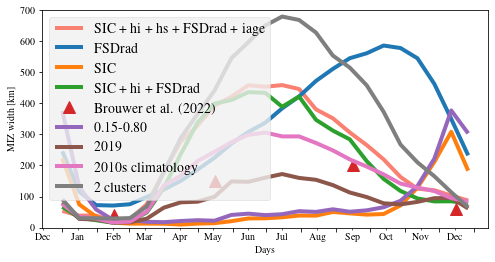

In [4]:
Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
x_dates = range(0,365)
x_dates = day_vec
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

brouwer_dates = [31+15,31+28+31+30+15,31+28+31+30+31+30+31+31+15,31+28+31+30+31+30+31+31+30+31+30+15]
brouwer_linear_centre = [36.187, 143.457, 192.569, 60.743]
brouwer_linear_lower = [20.679, 100.808, 125.363, 33.603]
brouwer_linear_upper = [60.743, 186.107, 275.283, 148.627]

print(brouwer_dates)

print(mdates.MonthLocator(bymonthday=15))

#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

#line_deviation = 1 * (effective_miz_width_array[day_vec,:].std(axis=1)/1000)

#lower = (mean - line_deviation)
#upper = (mean + line_deviation)

#plt.plot(x_dates, miz_width_array[day_vec,:].mean(axis=1)/1000, label = "Absolute")
mean = effective_miz_width_array_12345[day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "SIC + hi + hs + FSDrad + iage", color=Cmap[0,:])
mean = effective_miz_width_array_4[day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "FSDrad")
mean = effective_miz_width_array_1[day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "SIC")
mean = effective_miz_width_array_124[day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "SIC + hi + FSDrad")
plt.plot(brouwer_dates,[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.plot(x_dates, sic_width_array[day_vec,:].mean(axis=1)/1000, label = "0.15-0.80")

readfilename='/g/data/ia40/sea-ice-classification/mizWidth_2019.nc'
ds = xr.open_dataset(readfilename)
mean = ds['effective'][day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "2019")


readfilename='/g/data/ia40/sea-ice-classification/mizWidth_waves-10-clim-20102013.nc'
ds = xr.open_dataset(readfilename)
mean = ds['effective'][day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "2010s climatology")
#plt.fill_between(x_dates, lower, upper, color=Cmap[0,:], alpha=.1)

mean = effective_miz_width_array_2_clust[day_vec,:].mean(axis=1)/1000
plt.plot(x_dates, mean, label = "2 clusters")




#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("MIZ width [km]")
plt.legend()
ax.set_ylim([0, 700])
plt.show()

fig.autofmt_xdate()
savepath='/home/566/nd0349/notebooks/'
fig.savefig(savepath+'miz_width_'+str(year)+'_various.png', dpi = 300) 


In [6]:
mean = effective_miz_width_array_2_clust.mean(axis=1)/1000
mean

array([ 90.77767238,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  30.10938284,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,  30.15052683,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,  29.01285787,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
        30.57126702,          nan,          nan,       